# <p style="text-align: center;"> CSCI-455 | Computer Vision Systems </p>
<p style="text-align: center;">Circle Edges Detection and Hough Transform - Part II</p>
<p style="text-align: center;">Spring 2020</p>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

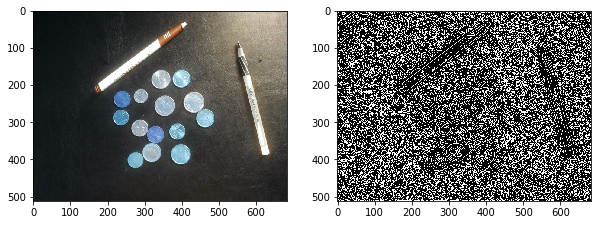

In [2]:
Box = cv2.imread('Input.jpg')

Box_edges = cv2.Canny(Box, 100, 200, 1, 7, True) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(Box, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Box_edges, cmap="gray")
plt.show()

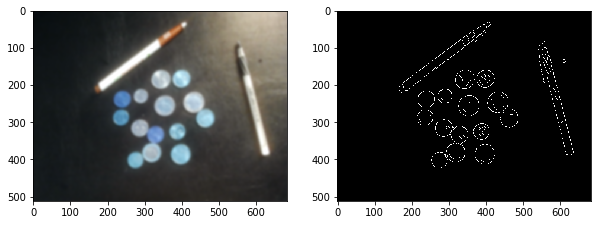

In [53]:
GauBox = cv2.GaussianBlur(Box, (15,15),3)

Box_edges = cv2.Canny(GauBox, 30, 40) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(GauBox, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Box_edges, cmap="gray")
plt.show()

Canny edge detection:              
https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

<div class="alert alert-block alert-warning">
    6. Application on Line Detection
</div>

### 1. Hough Transformation

In [54]:
image = Box_edges
def hough_transform(image):
    width = image.shape[1]
    height = image.shape[0]
    
    diag_len = np.ceil(np.sqrt(width * width + height * height)) # max distance for rho = length of diag.
    # 2 * diag length : for positive and negative max distance. 0 being diag_len
    rho_range = int(2*diag_len)
    
    # Initialize empty accumulator (filled with 0)
    hough_accu = np.zeros([rho_range, 180])    # 180 because theta from 0 to 180

    # get i and j indexes for all indexes 
    j_indexes, i_indexes = np.nonzero(image)

    # Browsing into each pixel of edges picture
    for k in range(len(j_indexes)):
        # getting indexes of edge
        i = i_indexes[k]
        j = j_indexes[k]

        # voting : for each value of theta
        for theta in range(0, 180):
            rho = int(np.round(i * np.cos(np.deg2rad(theta)) + j * np.sin(np.deg2rad(theta))) + diag_len)# positive index for rho
            hough_accu[rho, theta] += 1
    
    return hough_accu

### 2. Finding The Peak & Plotting..

In [55]:
# Peak finding
def peak_finding(hough_accu, min_distance = 45, max_peaks = 6, title ='Hough Transform'):

    coordinates = peak_local_max(hough_accu, min_distance=min_distance, exclude_border = False, num_peaks =max_peaks)
    
    loca_maxs_rho = coordinates[:, 0]
    loca_maxs_theta = coordinates[:, 1]
    plt.imshow(hough_accu, cmap='gray',aspect='auto')
    plt.title(title)

    # Annotate local maximum
    for i in range(len(loca_maxs_rho)):
        plt.annotate('X',xy=(loca_maxs_theta[i],loca_maxs_rho[i]), arrowprops=dict(facecolor='yellow', shrink=0.03),)
    plt.show()
    return loca_maxs_rho, loca_maxs_theta

### 3. Draw the Lines & Plotting..

In [56]:
def draw_line(image, loca_maxs_rho, loca_maxs_theta, rgb = (0,255,0)):
    image_copy = image.copy()
    width = image_copy.shape[1]
    height = image_copy.shape[0]
    diag_len = np.ceil(np.sqrt(width * width + height * height)) 
    for j in range(len(loca_maxs_rho)):
        rho = loca_maxs_rho[j] - diag_len
        theta = loca_maxs_theta[j]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x1=int(a*rho - diag_len*b) 
        y1=int(b*rho + diag_len*a)
        x2=int(a*rho + diag_len*b)
        y2=int(b*rho - diag_len*a)
        #print(x1,y1,x2,y2)
        cv2.line(image_copy, (x1,y1),(x2,y2), rgb, 3) # green line
        #print('Line {} | rho = {} theta = {}'.format(j,loca_maxs_rho[j], loca_maxs_theta[j]))
        plt.imshow(image_copy)
        plt.title('Detected Line')

    plt.show()
    return image_copy

### 4. Applying the functions

In [57]:
hough_accu = hough_transform(image)

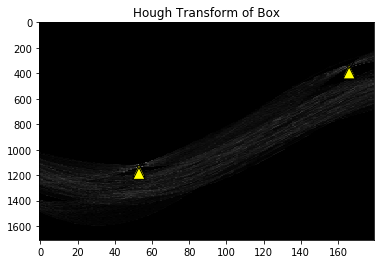

In [60]:
loca_maxs_rho, loca_maxs_theta = peak_finding(hough_accu, 10, max_peaks=4, title='Hough Transform of Box')

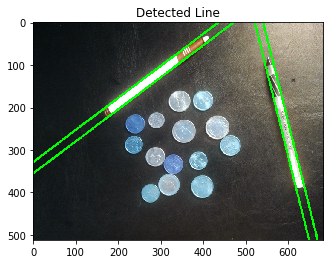

In [61]:
nDraw = draw_line(Box, loca_maxs_rho, loca_maxs_theta)

<div class="alert alert-block alert-warning">
    7. Application on Circle Detection
</div>

### 1. Circle Hough Transformation

In [84]:
def hough_transform_circle(image, image_edges, max_rad):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height = image.shape[0]
    width = image.shape[1]

    hough_accu = np.zeros([height, width, max_rad])    # Initialize empty accumulator (filled with 0)
    rr_indexes, cc_indexes = np.nonzero(image_edges)   # get row and columns indexes for all indexes 
    
    gxx = cv2.Sobel(image,cv2.CV_32FC1,1,0);    # compute gradient xx and yy from original picture
    gyy = cv2.Sobel(image,cv2.CV_32FC1,0,1);
    theta_values = cv2.phase(gxx,gyy,angleInDegrees=True);    # compute gradient direction for each point

    for k in range(len(rr_indexes)):     # Browsing into each pixel of edges picture
        # getting indexes of edge
        y = rr_indexes[k]
        x = cc_indexes[k]
        theta = np.deg2rad(theta_values[y,x])

        for radius in range(0, max_rad):
            a = int(x + radius * np.cos(theta))
            b = int(y + radius * np.sin(theta))
            if (b < height) and ( a>=0 ) and ( b>=0 ) and (a < width):
                hough_accu[b, a, radius] += 1

    return hough_accu

### 2. Finding The Peak & Plotting..

In [98]:
def peak_finding_circle(hough_accu_circle, min_dist = 20, max_peaks=10, title ='Hough Transform circle'): 
    
    coordinates = peak_local_max(hough_accu_circle, min_distance = min_dist, exclude_border = False, num_peaks = max_peaks)
    
    loca_maxs_b = coordinates[:, 0]
    loca_maxs_a = coordinates[:, 1]
    loca_maxs_radius = coordinates[:, 2]
    
    plt.imshow(hough_accu, cmap='gray',aspect='auto')
    plt.title(title)
    return loca_maxs_a, loca_maxs_b, loca_maxs_radius

### 3. Draw the Circles & Plotting..

In [64]:
def draw_circle(image, loca_maxs_a, loca_maxs_b, loca_maxs_radius, min_rad = 0, title = 'Detected Circle'):
    image_copy = image.copy()
    for j in range(len(loca_maxs_a)):
        a = loca_maxs_a[j]
        b = loca_maxs_b[j]
        radius = loca_maxs_radius[j]
        if (radius > min_rad): 
            cv2.circle(image_copy, (a, b), radius, (255,0,0), 2)
        #print('Cercle {} | b(row)= {} a(col) = {} radius = {}'.format(j,loca_maxs_b[j], loca_maxs_a[j], loca_maxs_radius[j]))
    plt.imshow(image_copy)
    plt.title(title)

    plt.show()
    return image_copy

### 4. Applying the functions

In [90]:
hough_accu_circle = hough_transform_circle(Box, Box_edges, 100)

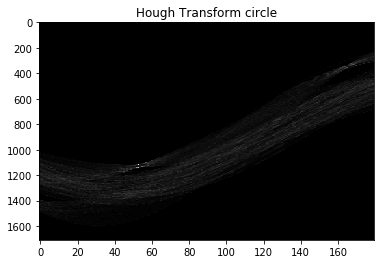

In [108]:
X, Y, r = peak_finding_circle(hough_accu_circle,  max_peaks = 15)

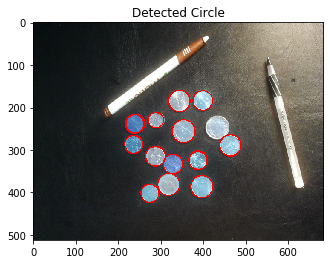

In [109]:
nDraw = draw_circle(Box, X, Y, r)

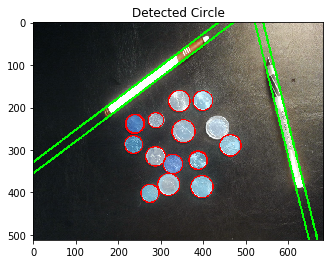

In [111]:
nDraw = draw_circle(nDraw, X, Y, r)

<u> Explination </u>

The hough method to detect the circles first compute the picture's gradient on x and y before calculating the phase between each gradient value. Hence we have, for each pixel, the corresponding value of theta that we are lookig for to detect the circle center.

This save computation time because there is no more need for iterating through all the theta values.


Here, local maximas are nicely detected, but we restricted the peaks to the 15 highest in order to see the circles corresponding to the coins detected, and only them.

We have used a gaussian filter with a sigma = 3. This helped reducing the noise and we can see that our Canny filter doesn't need very high tresholds to provides a good estimation of the edges on the pictures, which leads to good voting phase in the accumulator and a great detection of our circles parameters.

<div class="alert alert-block alert-warning">
    8. Application on Realistic Image
</div>

### Preprocessing

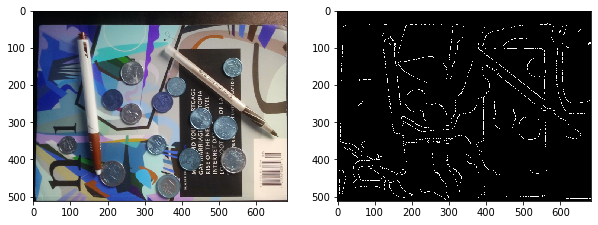

In [323]:
Box = cv2.imread('Input2.jpg')

GauBox = cv2.GaussianBlur(Box, (25,25),5)

Box_edges = cv2.Canny(GauBox, 40, 60, 1, 3, True)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(Box, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Box_edges, cmap="gray")
plt.show()

### 1. Line Detection

In [324]:
hough_accu = hough_transform(Box_edges)

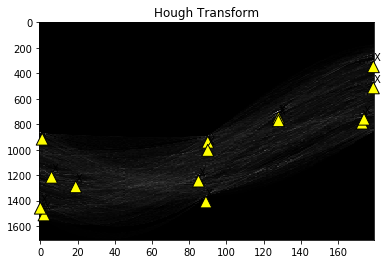

In [325]:
loca_maxs_rho, loca_maxs_theta = peak_finding(hough_accu, 20, max_peaks=15)

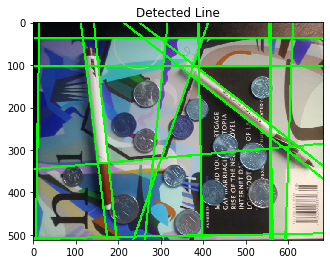

In [326]:
nDraw = draw_line(Box, loca_maxs_rho, loca_maxs_theta)

#### Why other lines ?
While looking at the edges detector, we can see that many straight edges are detected. Indeed, in the original picture, some straight line are detected on the 'magazine' where pens are. The Canny edge detector doesnt differenicate the edges of real objects from linear pattern drawn or simply present on the picture.

Here, to emphasize the probleme the number of peaks is not restricted (max = 15) so we can clearly see the problem we face (many lines detected).
#### Solution:
To solve this issue, we can :<br>
. 1 alter the peak finding or canny edge tresholdso we only detect stronger edges.<br>
. 2 check for a minium length of the lines <br>
. 3 check for eventual parallel lines (that) <br>

It turns out that, stronger edges, in our case, doesn't necessarily correspond to the pens'
boundaries. So the first solution could not really  be used.
The second option, won't be of great help neither, because, many 'lines' have almost the same size of our pens (the accumulator doesnt make the difference between many small cut lines or one big lines).

However, the third solution is interesting because, our pens have parallel edges so we could based our choice on that criteria : For each line found, is ther an other line with the same slope (filter on theta relation) ?

Also we should consider the 'width' of the pen. Indde, we can notice that lines corresponding of pens' edges are closer than other detected edges. Hence we can also apply an other 'filter' on top of the previous parallel filter that will keep lines parallel within a certain range (filter on rho relation).                
Rmk : in our case, we don't take into consideration the scale. But the width of pens on the picture depends on the level of zoom we are. This could be solved by considering a factor of zoom as a parameter.

### 2. Circle Detection

In [343]:
hough_accu_circle = hough_transform_circle(Box, Box_edges, max_rad= 100)

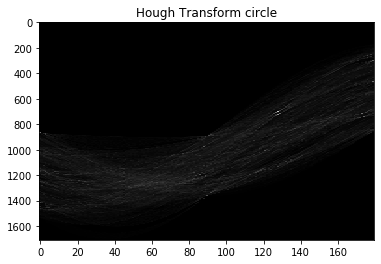

In [344]:
loca_maxs_a, loca_maxs_b, loca_maxs_radius =  peak_finding_circle(hough_accu_circle, max_peaks = 30)

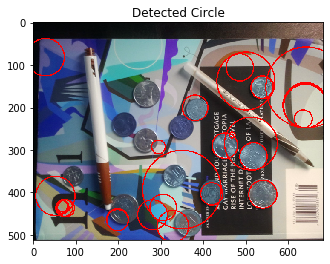

In [345]:
nDraw = draw_circle(Box, loca_maxs_a, loca_maxs_b, loca_maxs_radius)

We can see that there are many false positives and false-negatives. Curved line in the picture are also considered as circles, and some coins are note detected.

By looking at the original edges detector picture, we can notice that some curved line edges appear while some coins' edges are not clearly detected.

<u> Constraint on range of radius </u>

We could apply a filter that would keep only the circles within a min_range and max_range.
Since the max_range is already a parameter of our hough_accumulator_circle function, we just have to implement the min_range filter.

In [337]:
hough_accu_circle = hough_transform_circle(Box, Box_edges, max_rad= 40)

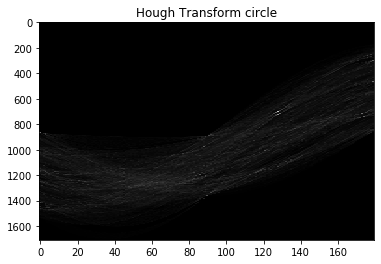

In [340]:
loca_maxs_a, loca_maxs_b, loca_maxs_radius =  peak_finding_circle(hough_accu_circle, max_peaks = 30, min_dist = 10)

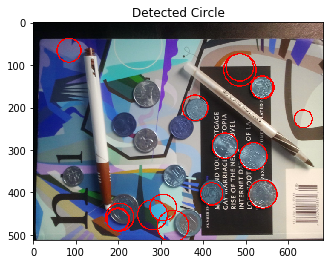

In [342]:
nDraw = draw_circle(Box, loca_maxs_a, loca_maxs_b, loca_maxs_radius, min_rad = 20)